In [1]:
import time
import numpy as np
from keras.models import Sequential
from keras.layers import Layer, Convolution2D, Activation, MaxPooling2D, Dense, Dropout, Flatten, \
ZeroPadding2D, BatchNormalization, UpSampling2D, Reshape, Permute
from keras import backend as K
from src.segnet_model import build_segnet_basic
from PIL import Image
from keras import utils
from keras import optimizers
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
%matplotlib inline
import json
from glob import glob
import os
import src.segtools as segtools
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
#from skimage import filters
#from skimage import morphology
from skimage.morphology import erosion as erode
from skimage.morphology import closing
from skimage.morphology import square
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

# First need to acquire the data from skynet-data repo that has our linked road and image data

In [4]:
# if we want to transfer the downloaded data from skynet to local data directory
#segtools.move_data('/data/train.txt', '/contents/images/train')
#segtools.move_data('/data/val.txt', '/contents/images/val')

In [2]:
#get the data

x_train, y_train = segtools.get_xy_data('/contents/images/train')
#print(x_train.shape, x_val.shape)
#print(y_train.shape, y_val.shape)
#get the number of classes
classes = np.unique(y_train)
num_classes = len(classes)
#x_train, y_train = segtools.data_generator(x_train, y_train) 
#TODO: use the keras package to generate data on the fly as batches to feed into model
#too much data to load into memory at the moment
# turn the raw data into usable data
x_train = segtools.pre_process_x(x_train)
#print(x_train.shape, x_val.shape)


In [3]:
y_train = segtools.pre_process_y(y_train, num_classes)
class_weights = segtools.get_weights(y_train)
print(class_weights)
#print(y_train.shape, y_val.shape)
print(np.max(y_train))

[ 19.30846472   0.51329189]
1


(16228, 256, 256, 3) (16228, 65536, 2)


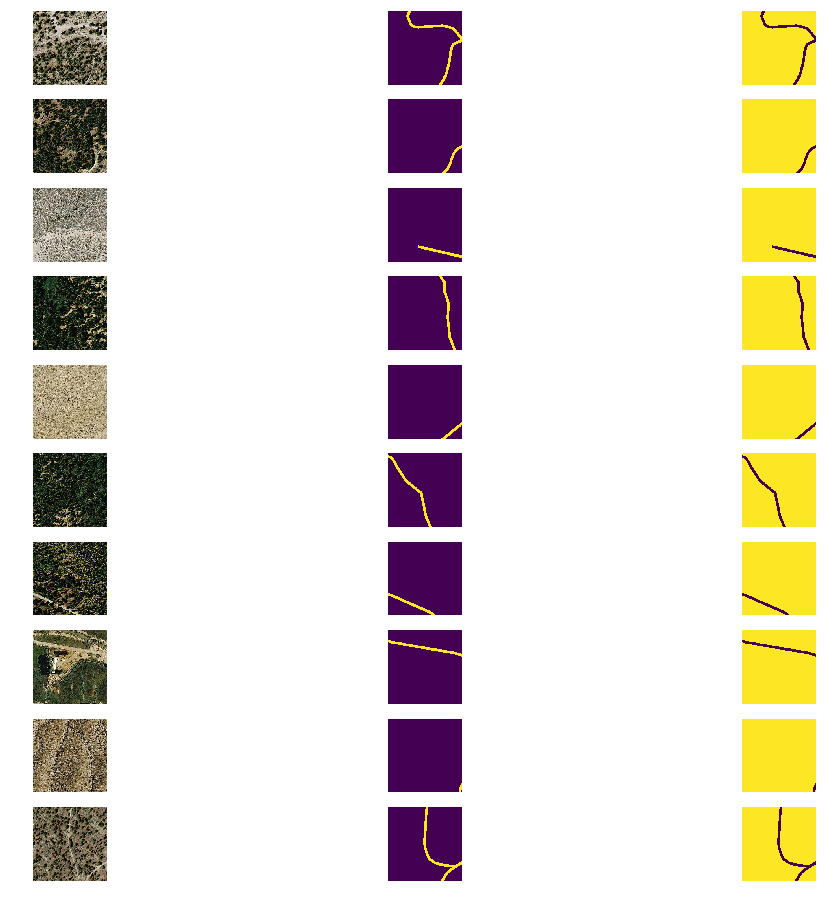

In [4]:
#quick sanity check
print(x_train.shape, y_train.shape)
n_previews = 10 
num_classes = 2 
f, ax = plt.subplots(n_previews,num_classes+1,figsize=(18, 16))
for j in range(n_previews):
    ax[j,0].imshow(x_train[j].astype('float32'))
    ax[j,0].axis('off')
    for i in range(1,num_classes+1):
        ax[j,i].imshow(y_train[j].reshape(x_train.shape[1], x_train.shape[2],num_classes)[:,:,i-1])
        ax[j,i].axis('off')

In [5]:
num_classes = 2
output_shape = x_train.shape[1:][0] * x_train.shape[1:][1] 
input_shape = (x_train.shape[1],x_train.shape[2],x_train.shape[3])
K.clear_session() #make sure previous sessions are cleared.
segnet_basic = build_segnet_basic(num_classes, input_shape, output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Layer)              (None, 256, 256, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 258, 258, 3)       0         
_________________________________________________________________
Conv_1a (Conv2D)             (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 258, 258, 32)      0         
_________________________________________________________________
Conv_1b (Conv2D)             (None, 256, 256, 32)      9248      
__________

In [6]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(time.time()))
# we can just import the model here instead of defining the architecture above
#segnet_basic = segnet_utils.import_model(model_json, model_weights)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
segnet_basic.compile(loss='categorical_crossentropy', \
                     optimizer=opt, metrics=['categorical_accuracy'])
segnet_basic.fit(x_train, y_train, \
                 batch_size=20, epochs=1, class_weight=class_weights,\
                 shuffle=True, verbose=True, callbacks=[tensorboard])


Epoch 1/1
16228/16228 [==============================] - 655s 40ms/step - loss: 0.1249 - categorical_accuracy: 0.9697


In [7]:
t = time.strftime('%Y%m%d%H%M', time.gmtime())
os.makedirs('./fit_models/%s'%t)
segnet_basic.save_weights('./fit_models/%s/seg_net.h5'%t)
# serialize model to JSON

with open('./fit_models/%s/seg_net.json'%t, 'w') as outfile:
    outfile.write(json.dumps(json.loads(segnet_basic.to_json()), indent=2))

In [8]:
x_val, y_val = segtools.get_xy_data('/contents/images/val')
x_val = segtools.pre_process_x(x_val)
y_val = segtools.pre_process_y(y_val, num_classes)

In [10]:
pr = segnet_basic.predict(x_val)
predictions = []
for i in range(len(pr)):
    predictions.append(pr[i].reshape((256,256,num_classes)))
predictions = np.array(predictions)
norm_pred = segtools.normalize_stack(predictions[:,:,:,0])

0.0265837753126


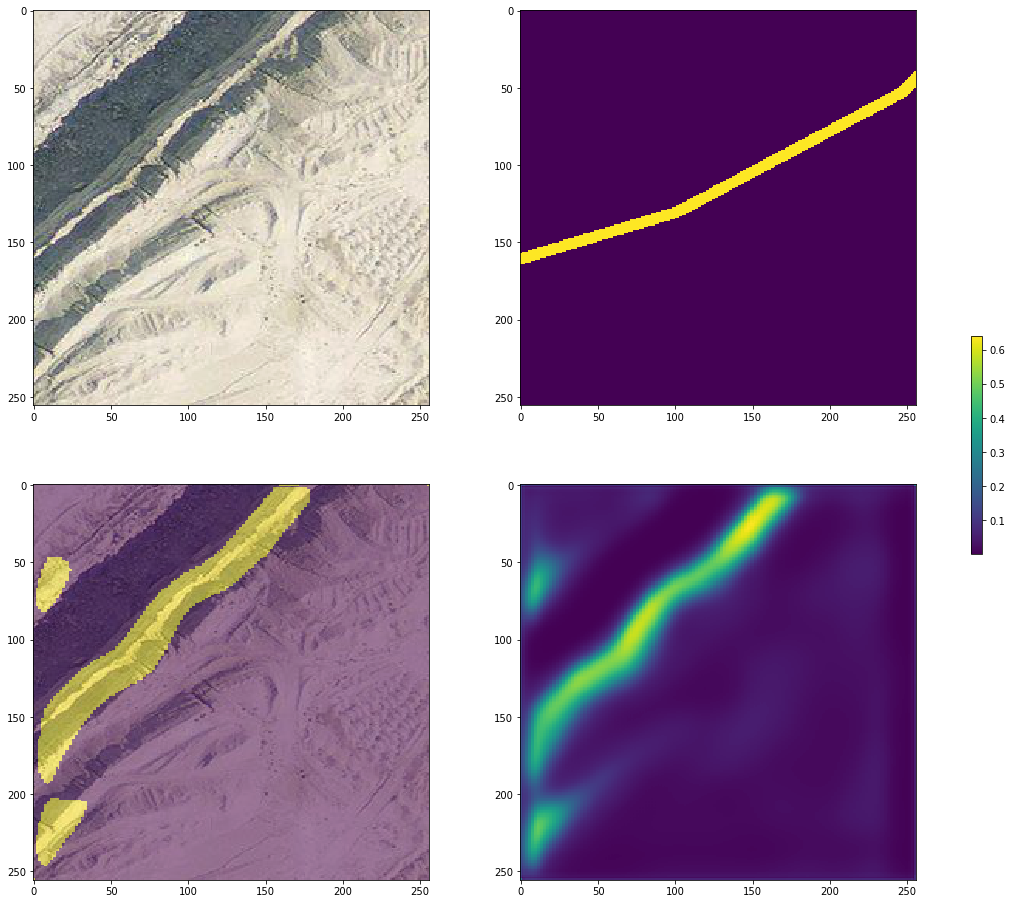

In [17]:
thr=class_weights[1]/class_weights[0]
print(thr)
thr=0.2
f, ax = plt.subplots(2,2, figsize=(20, 16))
sample=np.random.randint(0, len(x_val))
ax[0,0].imshow(x_val[sample].astype('float32'))
ax[0,1].imshow(y_val[sample].reshape(256,256,num_classes)[:,:,0])
ax[1,0].imshow(x_val[sample].astype('float32'))
mask = np.zeros((256,256))
mask[norm_pred[sample]>=thr] = 1
ax[1,0].imshow(mask,alpha=0.5)

im = ax[1,1].imshow(norm_pred[sample])
f.colorbar(im, ax=ax.ravel().tolist(), shrink=0.25)

In [ ]:
# construct a confusion matrix using various masks...
t_min = 0
t_max = 0.2
n_thr = 2
c = pr[:,:,0]
c.reshape((c.shape[0]*c.shape[1]))
def generate_threshold_masks(c, n_thr, t_min, t_max):
    input_shape = np.shape(c)
    masks = np.zeros((n_thr, np.shape(c))).astype('bool')
    thr = np.linspace(t_min, t_max, n_thr) 
    for i in range(len(t)):
        masks[i][c>=thr[i]] = True 
    return(masks)
masks = generate_threshold_masks(c, n_thr, t_min, t_max)

In [185]:
target = y_val[:,:,0].astype('bool')
n_cells = np.shape(target)[0] * np.shape(target)[1]

#overall accuracy.
sensitivity = np.zeros(len(masks)) 
specificity = np.zeros(len(masks)) 
for i in range(len(masks)):
    print(np.sum((target & masks[i]))/n_cells)
    print(np.sum((~target & ~masks[i]))/n_cells)

0.0254925460778
0.0
0.0181769595069
0.880840539114
0.0153784496986
0.923747120212


NameError: name 'erode' is not defined

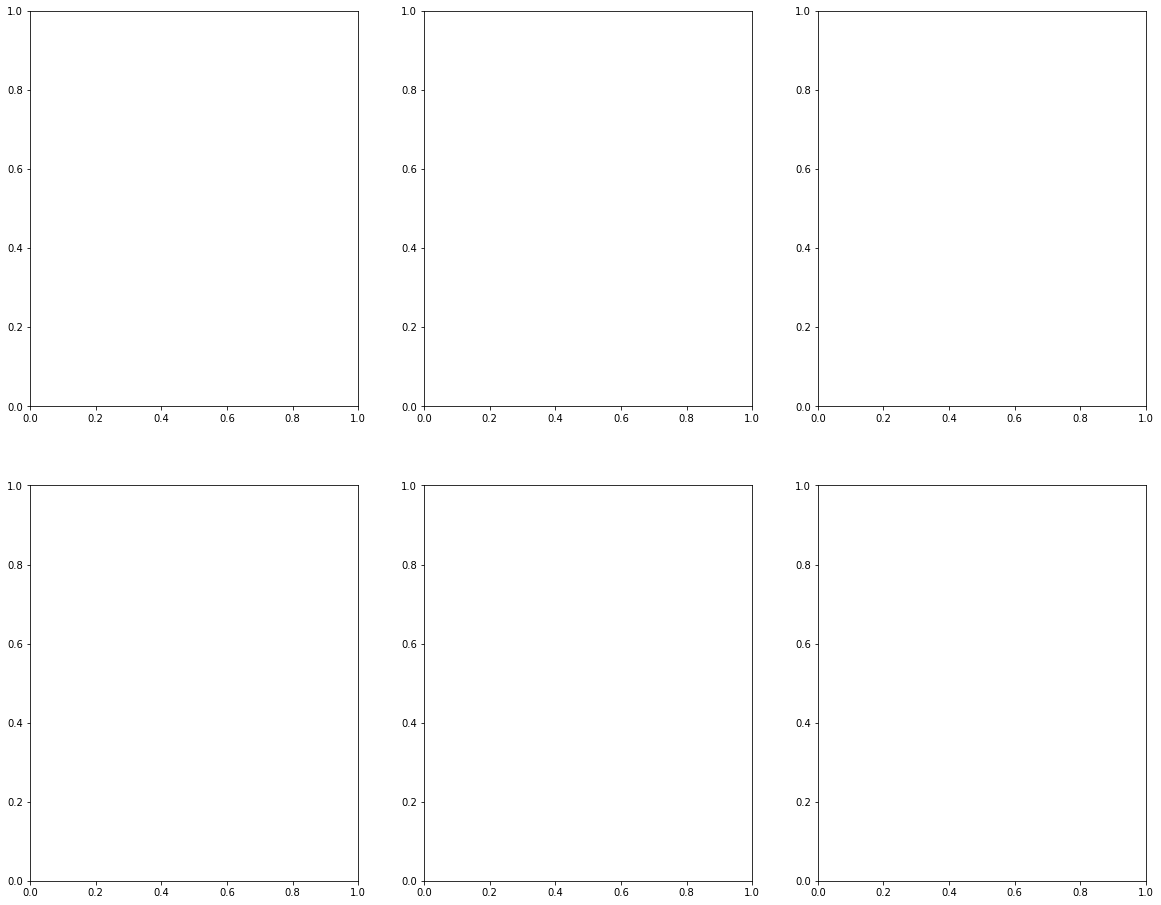

In [334]:
im = predictions[sample][:,:,0]
x_ = x_val[sample]
y_ = y_val[sample].reshape(256,256,num_classes)[:,:,0]
f, ax = plt.subplots(2,3, figsize=(20, 16))
ero1 = erode(im, square(3))
ero2 = erode(im, square(7))
ero3 = erode(erode(im,square(7)),square(3))
masked = np.zeros(np.shape(im))
masked[im>=thr] = 1
masked = erode(erode(masked, square(3)),square(3))
diff = y_ - masked
tv = denoise_tv_chambolle(im, weight=0.2)
ax[0,0].imshow(im)
ax[0,1].imshow(ero1)
ax[0,2].imshow(ero3)
ax[1,0].imshow(tv)
ax[1,1].imshow(x_)
ax[1,1].imshow(masked, alpha = 0.5)
ax[1,2].imshow(closing(closing(erode(masked, square(3)))))

# Try predicting on the entire Tonopah dataset

## See 'predictions.ipynb'